In [116]:
!pip freeze

absl-py==0.10.0
appdirs==1.4.4
astor==0.8.1
astroid==2.4.2
attrs==20.2.0
Automat==20.2.0
backcall==0.2.0
beautifulsoup4==4.9.1
branca==0.4.1
bs4==0.0.1
certifi==2020.6.20
cffi==1.14.2
chardet==3.0.4
click==7.1.2
colorama==0.4.3
constantly==15.1.0
cryptography==3.1
cssselect==1.1.0
cycler==0.10.0
decorator==4.4.2
distlib==0.3.1
filelock==3.0.12
Flask==1.1.2
folium==0.11.0
gast==0.4.0
grpcio==1.32.0
h5py==2.10.0
hyperlink==20.0.1
idna==2.10
incremental==17.5.0
ipython==7.19.0
ipython-genutils==0.2.0
isort==5.4.2
itemadapter==0.1.0
itemloaders==1.0.3
itsdangerous==1.1.0
jedi==0.17.2
Jinja2==2.11.2
jmespath==0.10.0
joblib==0.16.0
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.2
kiwisolver==1.2.0
lazy-object-proxy==1.4.3
lxml==4.5.2
Markdown==3.2.2
MarkupSafe==1.1.1
matplotlib==3.3.2
mccabe==0.6.1
numpy==1.19.1
pandas==1.1.2
parsel==1.6.0
parso==0.7.1
patsy==0.5.1
pickleshare==0.7.5
Pillow==7.2.0
pipenv==2020.8.13
prompt-toolkit==3.0.8
Protego==0.1.16
protobuf==3.13.0
psycopg2==2.8.6
py

## Importar librerías requeridas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

from statsmodels.formula.api import ols
from sklearn.metrics import roc_curve, auc
import statsmodels.formula.api as sfm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

C:\Users\LeoJimenez\AppData\Roaming\Python\Python38\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Lectura de tablas

In [3]:
df_clients = pd.read_csv('input1_clientes_estructura.csv', delimiter=';',
                        dtype={'Cliente': 'category', 'Regional2':'category', 'Gerencia2':'category',
                              'SubCanal2':'category', 'Categoria':'category', 'Nevera':'category'})
df_clients.head(2)

,Cliente,Regional2,Gerencia2,SubCanal2,Categoria,Nevera
0,1,Regional 1,Gerencia_1,Subcanal_1,Categoria_1,0
1,2,Regional 1,Gerencia_1,Subcanal_1,Categoria_1,0


In [4]:
df_sales = pd.read_csv('input2_clientes_venta.csv', delimiter=';',
                        dtype={'Año': 'category', 'Mes':'category', 'Cliente':'category',
                              'SegmentoPrecio2':'category', 'Marca2':'category', 'Nevera':'category',
                              'Cupo2':'category', 'CapacidadEnvase2':'category', 'Volumen':'float64',
                              'disc':'float64', 'nr':'float64'})

# Se crea una columna ficticia de día para crear la columna "date" que nos permitirá realizar análisis exploratorios
df_sales['day'] = 1
# EL método .to_datetime requiere que los nombres sean en inglés
df_sales = df_sales.rename(columns={'Año':'year', 'Mes':'month'})
df_sales['date'] = pd.to_datetime(df_sales[['year', 'month', 'day']])
# Se borra la columna que sobra
del df_sales['day']
df_sales.head(2)

,year,month,Cliente,SegmentoPrecio2,Marca2,Cupo2,CapacidadEnvase2,Volumen,disc,nr,date
0,2019,5,10,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,0.112229,-30.590603,900.328567,2019-05-01
1,2019,5,10,SegmentoPrecio_1,Marca_2,Cupo_2,CapacidadEnvase_10,0.021734,0.000000,149.184463,2019-05-01


In [5]:
df_sales.shape

(1406116, 11)

## Es momento de analizar qué hay en cada tabla

In [6]:
# Función para realizar histogramas de manera sencilla
def myhist( data, title, xlab, ax, n_bins = 100, density = False, range = [0,100] ):
    #fig = plt.figure( figsize=(10,7.5) )
    #ax = plt.gca()
    n, bins, patches = ax.hist( data, bins = n_bins, density = density, range = range )
    plt.xlabel( xlab )
    if density:
        plt.ylabel( "Density" )
    else:
        plt.ylabel( "Counts" )
    plt.title( title )

In [7]:
df_clients.describe(include='all')

,Cliente,Regional2,Gerencia2,SubCanal2,Categoria,Nevera
count,20921,20921,20921,20921,20921,20921
unique,20921,1,11,32,6,2
top,9999,Regional 1,Gerencia_10,Subcanal_3,Categoria_2,0
freq,1,20921,5441,8217,8773,12598


1. Se observa que los 20921 clientes pertenecen a una única `Regional2` por lo que podemos descartar esta categoría que no aporta valor.
2. La variable `Nevera` se encuentra imbalanceada.

In [8]:
df_sales.describe(include='all')

,year,month,Cliente,SegmentoPrecio2,Marca2,Cupo2,CapacidadEnvase2,Volumen,disc,nr,date
count,1406116,1406116,1406116,1406116,1406116,1406116,1406116,1.406116e+06,1.406116e+06,1.406116e+06,1406116
unique,2,12,17010,3,39,5,17,NaN,NaN,NaN,17
top,2020,8,14162,SegmentoPrecio_1,Marca_1,Cupo_2,CapacidadEnvase_10,NaN,NaN,NaN,2020-08-01 00:00:00
freq,728490,184666,591,991679,406526,786172,707919,NaN,NaN,NaN,97020
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-01 00:00:00
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.294363e-01,-1.335855e+02,1.704834e+03,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.395798e+00,1.491833e+03,1.047079e+04,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,-4.794567e+05,0.000000e+00,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.173441e-02,-2.877037e+01,1.778085e+02,NaN


1. Más de un 80% de todos los clientes han realizado al menos una compra en los últimos dos años.
2. El `SegmentoPrecio_1` corresponde a un 70% de los datos.
3. La `Marca_1` equivale al 29% de todas las incluidas en el estudio.
4. `Cupo_2` y `CapacidadEnvase_10` representan 56% y 50% de sus categorías, respectivamente.

Estas primeras conclusiones nos indican que hay imbalance en las variables, el cual debe ser tenido en cuenta en las futuras conclusiones de nuestros modelos. En cuanto a las variables numéricas:

5. Las distribuciones de `Volumen` y `nr` se encuentran sesgadas, dado el cambio de escala entre el 50% y el 75% de los datos. Con el fin de tener mejor precisión en el modelo será necesario realizar un procedimiento de eliminación de estos "Outliers".


### Combinar ambas tablas para identificar las razones de estos casos atípicos

In [9]:
del df_clients['Regional2']

In [10]:
df_full = pd.merge(left=df_sales, right=df_clients, on='Cliente')

In [11]:
#Revisar estos casos atípicos
df_full[df_full['Volumen'].rank(ascending=False) < 11]

,year,month,Cliente,SegmentoPrecio2,Marca2,Cupo2,CapacidadEnvase2,Volumen,disc,nr,date,Gerencia2,SubCanal2,Categoria,Nevera
298486,2020,9,13069,SegmentoPrecio_1,Marca_4,Cupo_2,CapacidadEnvase_10,300.000000,0.000000,2.016562e+06,2020-09-01,Gerencia_1,Subcanal_13,Categoria_2,1
366610,2020,6,17814,SegmentoPrecio_1,Marca_1,Cupo_2,CapacidadEnvase_10,177.135405,-192430.928280,1.243243e+06,2020-06-01,Gerencia_10,Subcanal_16,Categoria_3,1
1176344,2019,12,8559,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,230.863515,-153623.530367,1.955204e+06,2019-12-01,Gerencia_10,Subcanal_26,Categoria_4,0
1186682,2019,8,2686,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,169.334203,-68641.511981,1.336145e+06,2019-08-01,Gerencia_9,Subcanal_13,Categoria_1,1
1186690,2019,9,2686,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,224.821877,-3015.828015,1.911068e+06,2019-09-01,Gerencia_9,Subcanal_13,Categoria_1,1
1186711,2020,9,2686,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,243.161895,0.000000,2.302965e+06,2020-09-01,Gerencia_9,Subcanal_13,Categoria_1,1
1186723,2020,7,2686,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,171.700355,-47702.079947,1.578700e+06,2020-07-01,Gerencia_9,Subcanal_13,Categoria_1,1
1186730,2019,11,2686,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,262.222047,-3015.737301,2.229575e+06,2019-11-01,Gerencia_9,Subcanal_13,Categoria_1,1
1186735,2020,8,2686,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,166.000079,-143166.334750,1.411601e+06,2020-08-01,Gerencia_9,Subcanal_13,Categoria_1,1
1286285,2020,9,10893,SegmentoPrecio_1,Marca_5,Cupo_1,CapacidadEnvase_10,178.096066,-33825.618154,1.702600e+06,2020-09-01,Gerencia_6,Subcanal_13,Categoria_2,1


In [12]:
#Revisión de correlación de alguna variable cuando se supera el límite ya que es posible que se deba a cierta categoría dentro
# de alguna de las variables

variables = ['Marca2', 'Cupo2', 'CapacidadEnvase2', 'Gerencia2', 'SubCanal2', 'Categoria', 'Nevera']
threshold_vol = df_full['Volumen'].quantile(0.85)
threshold_corr = 0.2

for var in variables:
    corrs = pd.get_dummies(df_full[(df_full['Volumen'] > threshold_vol)][[var, 'Volumen']]).corr()['Volumen'][1:]
    if any(corrs > threshold_corr):
        print(corrs[corrs > threshold_corr])

SubCanal2_Subcanal_13    0.286906
Name: Volumen, dtype: float64


Estos datos antípicos sí presentan correlación con el `SubCanal_13` por lo que se dejarán estos predictores.

In [13]:
df_full_clean = df_full[(df_full['SubCanal2'] == 'Subcanal_13') | (df_full['Volumen'] < threshold_vol)].copy()
df_full_clean.head(2)

,year,month,Cliente,SegmentoPrecio2,Marca2,Cupo2,CapacidadEnvase2,Volumen,disc,nr,date,Gerencia2,SubCanal2,Categoria,Nevera
0,2019,5,10,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,0.112229,-30.590603,900.328567,2019-05-01,Gerencia_3,Subcanal_1,Categoria_2,1
1,2019,5,10,SegmentoPrecio_1,Marca_2,Cupo_2,CapacidadEnvase_10,0.021734,0.000000,149.184463,2019-05-01,Gerencia_3,Subcanal_1,Categoria_2,1


## Análisis exploratorio de las variables

### Distribuciones

Una vez se ha definido el set de datos inicial, se evalúan las distribuciones marginales de las variables.

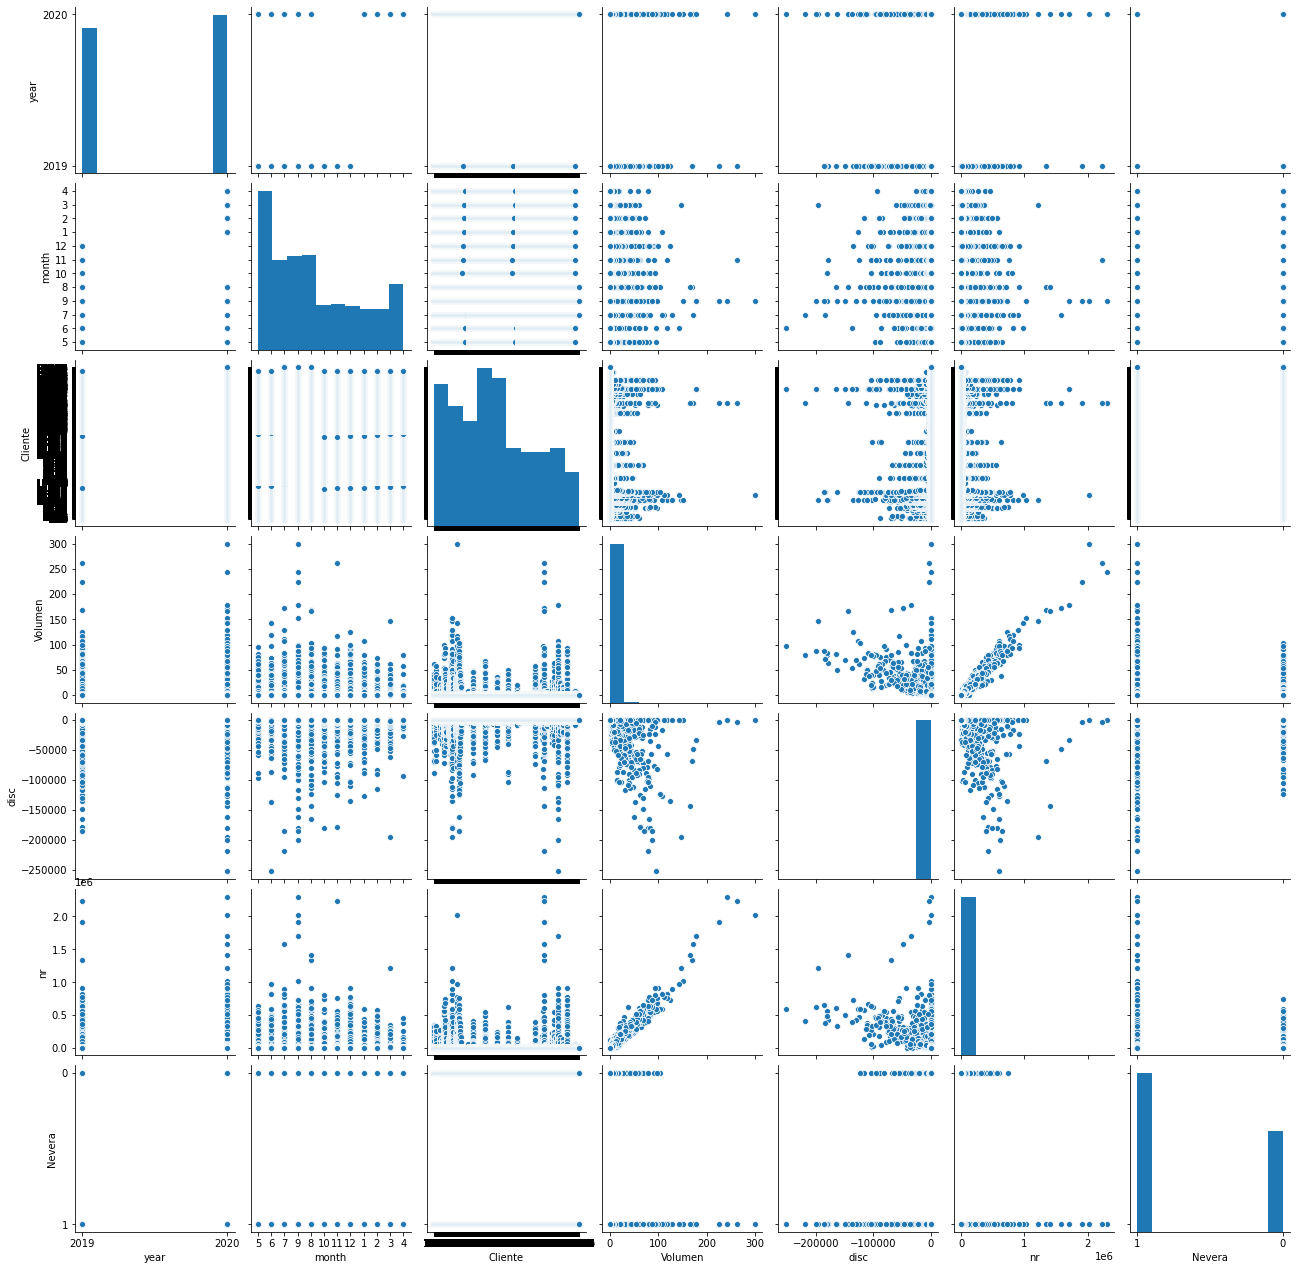

In [101]:
sns.pairplot(data=df_full_clean)

1. Existen a *priori* tres tipos de clientes, más adelante lo tendremos en cuenta para la clasificación de las variables en pequeños subgrupos.
2. El descuento parece influir en el volumen.

### Influencia del descuento en volumen

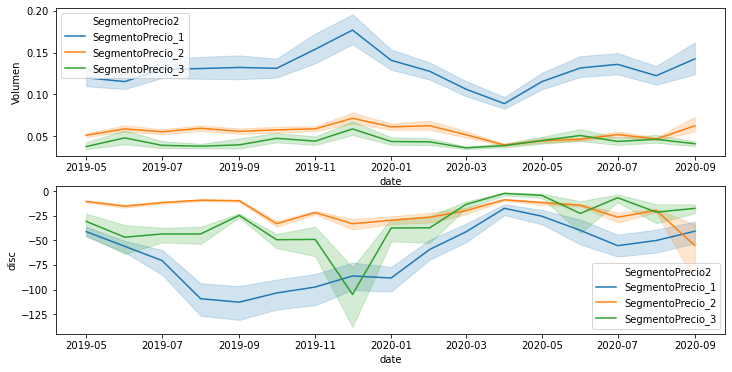

In [14]:
fig, ax = plt.subplots(2,1, figsize=(12,6))

sns.lineplot(x='date', y='Volumen', data=df_full_clean, hue='SegmentoPrecio2', ax=ax[0])
sns.lineplot(x='date', y='disc', data=df_full_clean, hue='SegmentoPrecio2', ax=ax[1])

plt.show()

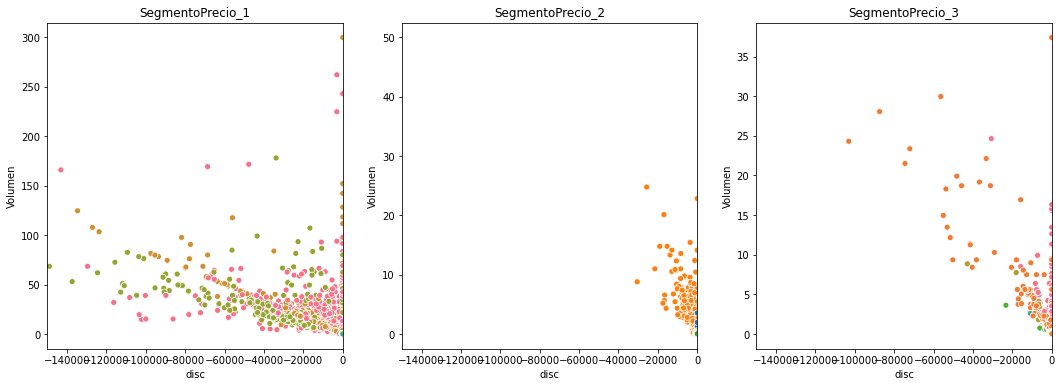

In [15]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

for i, var in enumerate(list(df_full_clean.SegmentoPrecio2.unique())):
    
    sns.scatterplot(x='disc', y='Volumen', hue='Marca2', data=df_full_clean[df_full_clean['SegmentoPrecio2'] == var],
                    legend=False, ax=ax[i])
    ax[i].set_title(var)
    ax[i].set_xlim(-150000, 0)

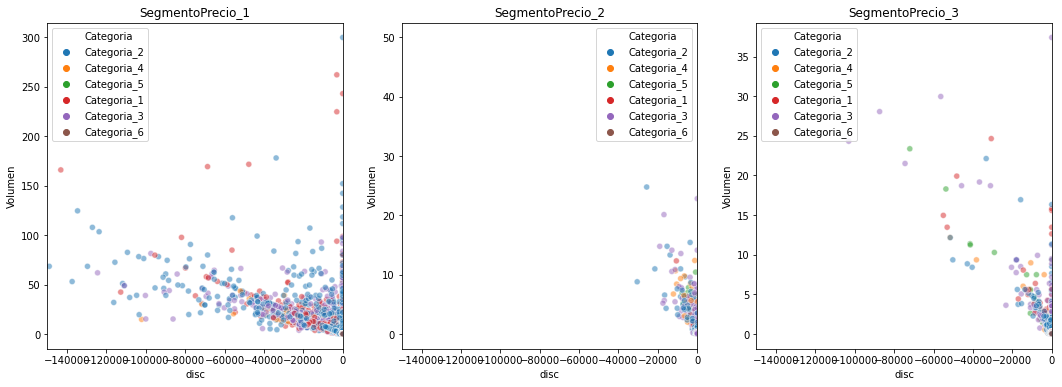

In [16]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

for i, var in enumerate(list(df_full_clean.SegmentoPrecio2.unique())):
    
    sns.scatterplot(x='disc', y='Volumen', hue='Categoria', data=df_full_clean[df_full_clean['SegmentoPrecio2'] == var],
                    legend='brief', ax=ax[i], alpha=0.5)
    ax[i].set_title(var)
    ax[i].set_xlim(-150000, 0)

El efecto del descuento se ve más visible para la `Categoria` 1 y el `SegmentoPrecio2` 1, por lo que en nuestra variable de respuesta deberemos tener en cuenta este factor. 

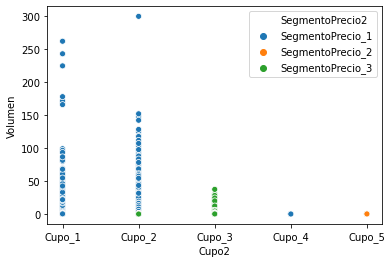

In [17]:
sns.scatterplot(x='Cupo2', y='Volumen', hue='SegmentoPrecio2', data=df_full_clean);

Respecto a la distribución de los diferentes cupos encontramos que uno de ellos se ajusta a solo uno de los segmentos. Por lo que podría presentarse colinearidad.

### Ingeniería de características (Feature Engineering)

Para generar la predicción se busca crear una nueva característica que de cuenta de la probabilidad de compra.

In [18]:
limit= df_full_clean['nr'].quantile(0.5)

df_full_clean['score'] = np.where(df_full_clean['nr'] < limit, 0, 1)
df_full_clean.head(2)

,year,month,Cliente,SegmentoPrecio2,Marca2,Cupo2,CapacidadEnvase2,Volumen,disc,nr,date,Gerencia2,SubCanal2,Categoria,Nevera,score
0,2019,5,10,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,0.112229,-30.590603,900.328567,2019-05-01,Gerencia_3,Subcanal_1,Categoria_2,1,1
1,2019,5,10,SegmentoPrecio_1,Marca_2,Cupo_2,CapacidadEnvase_10,0.021734,0.000000,149.184463,2019-05-01,Gerencia_3,Subcanal_1,Categoria_2,1,0


## Modelado

In [111]:
inputs = df_full_clean.iloc[:,0:15]
output = df_full_clean.iloc[:,15]

#No se tiene en cuenta la variable cliente ya que es redundante
inputs = inputs.drop(columns=['Volumen','nr','disc','date','Cliente'])
inputs = pd.get_dummies(inputs)

train_test_split(inputs, output)
x_train, x_test, y_train, y_test=train_test_split(inputs, output, train_size=0.8, random_state=60)
print('tamaños de train , test ',x_train.shape, x_test.shape)

#Regresión logística
reg = LogisticRegression(penalty='l1', solver='liblinear')
reg.fit(x_train,y_train)
roc=roc_auc_score(y_test, reg.predict_proba(x_test)[:,1])

print('El puntaje del método para predecir el train: ', reg.score(x_train,y_train))
print('El puntaje del método para predecir el test: ', reg.score(x_test,y_test))
print('El puntaje del método para predecir el test con roc_auc: ', roc)


tamaños de train , test  (962144, 129) (240536, 129)
El puntaje del método para predecir el train:  0.6549840772275252
El puntaje del método para predecir el test:  0.6554029334486314
El puntaje del método para predecir el test con roc_auc:  0.71593141042059


In [221]:
inputs = df_full_clean.iloc[:,0:15]
output = df_full_clean.iloc[:,15]

#No se tiene en cuenta la variable cliente ya que es redundante
inputs = inputs.drop(columns=['Volumen','nr','disc','date','Cliente','month','year','Gerencia2', 'SubCanal2',
                             'Nevera', 'Categoria'])
inputs = pd.get_dummies(inputs)

train_test_split(inputs, output)
x_train, x_test, y_train, y_test=train_test_split(inputs, output, train_size=0.8, random_state=60)
print('tamaños de train , test ',x_train.shape, x_test.shape)

#Regresión logística
reg2 = LogisticRegression(penalty='l1', solver='liblinear')
reg2.fit(x_train,y_train)
roc=roc_auc_score(y_test, reg2.predict_proba(x_test)[:,1])

print('El puntaje del método para predecir el train: ', reg2.score(x_train,y_train))
print('El puntaje del método para predecir el test: ', reg2.score(x_test,y_test))
print('El puntaje del método para predecir el test con roc_auc: ', roc)

tamaños de train , test  (962144, 64) (240536, 64)
El puntaje del método para predecir el train:  0.619530964179998
El puntaje del método para predecir el test:  0.6210421724814581
El puntaje del método para predecir el test con roc_auc:  0.6761852930111699


In [233]:
dft_results = dft.copy()
dft_results[['Marca1', 'Marca2', 'Marca3', 'Marca_Inno1', 'Marca_Inno2']] = predict_values(reg2, list(x_test.columns))
dft_results

,Cliente,Marca1,Marca2,Marca3,Marca_Inno1,Marca_Inno2
0,10,0.226422,0.525139,0.699876,0.479109,0.563555
1,12,0.226422,0.525139,0.699876,0.479109,0.563555
2,14,0.226422,0.525139,0.699876,0.479109,0.563555
3,15,0.226422,0.525139,0.699876,0.479109,0.563555
4,18,0.226422,0.525139,0.699876,0.479109,0.563555
...,...,...,...,...,...,...
9297,20186,0.226422,0.525139,0.699876,0.479109,0.563555
9298,20261,0.226422,0.525139,0.699876,0.479109,0.563555
9299,20309,0.226422,0.525139,0.699876,0.479109,0.563555
9300,20360,0.226422,0.525139,0.699876,0.479109,0.563555


In [231]:
#dft_results.to_csv('modelo1.csv', sep=',')

In [118]:
x_test

,SegmentoPrecio2_SegmentoPrecio_1,SegmentoPrecio2_SegmentoPrecio_2,SegmentoPrecio2_SegmentoPrecio_3,Cupo2_Cupo_1,Cupo2_Cupo_2,Cupo2_Cupo_3,Cupo2_Cupo_4,Cupo2_Cupo_5,CapacidadEnvase2_CapacidadEnvase_1,CapacidadEnvase2_CapacidadEnvase_10,...,SubCanal2_Subcanal_31,SubCanal2_Subcanal_32,SubCanal2_Subcanal_4,SubCanal2_Subcanal_5,SubCanal2_Subcanal_6,SubCanal2_Subcanal_7,SubCanal2_Subcanal_8,SubCanal2_Subcanal_9,Nevera_0,Nevera_1
476298,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
127130,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
727972,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1307116,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
471064,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944344,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
284929,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1344047,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
28494,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
inputs = df_full_clean.iloc[:,0:15]
output = df_full_clean.iloc[:,15]

#No se tiene en cuenta la variable cliente ya que es redundante
inputs = inputs.drop(columns=['Volumen','nr','disc','date','month','year', 'Marca2', 'Cliente', 'Categoria'])
inputs = pd.get_dummies(inputs)

train_test_split(inputs, output)
x_train, x_test, y_train, y_test=train_test_split(inputs, output, train_size=0.8, random_state=60)

rfc = RandomForestClassifier(n_estimators=1000, max_depth=10)
rfc.fit(x_train, y_train)
print((rfc.score(x_train,y_train)),rfc.score(x_test,y_test),roc_auc_score(y_test, rfc.predict_proba(x_test)[:,1]))

In [123]:
print(rfc.get_params)

<bound method BaseEstimator.get_params of RandomForestClassifier()>


### Evaluate Results

In [67]:
dft = pd.read_csv('input3_clientes_test.csv', delimiter=';', dtype={'Cliente': 'category'})

In [ ]:
dft_results = dft.copy()
dft_results[['Marca1', 'Marca2', 'Marca3', 'Marca_Inno1', 'Marca_Inno2']] = predict_values(rfc, list(x_test.columns))
dft_results

In [121]:
dft_results.to_csv('modelo3.csv', sep=',', index=False)

In [128]:
!pip install xgboost

  Using cached xgboost-1.2.1.tar.gz (774 kB)
  Running setup.py clean for xgboost
Failed to build xgboost
    Running setup.py install for xgboost: started
    Running setup.py install for xgboost: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'c:\users\leojimenez\appdata\local\programs\python\python38-32\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\LeoJimenez\\AppData\\Local\\Temp\\pip-install-hk658csw\\xgboost\\setup.py'"'"'; __file__='"'"'C:\\Users\\LeoJimenez\\AppData\\Local\\Temp\\pip-install-hk658csw\\xgboost\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\LeoJimenez\AppData\Local\Temp\pip-wheel-vogu72u5'
       cwd: C:\Users\LeoJimenez\AppData\Local\Temp\pip-install-hk658csw\xgboost\
  Complete output (1051 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win32-3.8
  creating build\lib.win32-3.8\xgboost
  copying xgboost\callback.py -> build\lib.win32-3.8\xgboost
  copying xgboost\compat.py -> build\lib.win32-3.8\xgbo

  copying xgboost\dmlc-core\include\dmlc\memory.h -> build\lib.win32-3.8\xgboost\dmlc-core\include\dmlc
  copying xgboost\dmlc-core\include\dmlc\memory_io.h -> build\lib.win32-3.8\xgboost\dmlc-core\include\dmlc
  copying xgboost\dmlc-core\include\dmlc\omp.h -> build\lib.win32-3.8\xgboost\dmlc-core\include\dmlc
  copying xgboost\dmlc-core\include\dmlc\optional.h -> build\lib.win32-3.8\xgboost\dmlc-core\include\dmlc
  copying xgboost\dmlc-core\include\dmlc\parameter.h -> build\lib.win32-3.8\xgboost\dmlc-core\include\dmlc
  copying xgboost\dmlc-core\include\dmlc\recordio.h -> build\lib.win32-3.8\xgboost\dmlc-core\include\dmlc
  copying xgboost\dmlc-core\include\dmlc\registry.h -> build\lib.win32-3.8\xgboost\dmlc-core\include\dmlc
  copying xgboost\dmlc-core\include\dmlc\serializer.h -> build\lib.win32-3.8\xgboost\dmlc-core\include\dmlc
  copying xgboost\dmlc-core\include\dmlc\strtonum.h -> build\lib.win32-3.8\xgboost\dmlc-core\include\dmlc
  copying xgboost\dmlc-core\include\dmlc\thread_g

  copying xgboost\rabit\guide\README -> build\lib.win32-3.8\xgboost\rabit\guide
  copying xgboost\rabit\guide\basic.cc -> build\lib.win32-3.8\xgboost\rabit\guide
  copying xgboost\rabit\guide\basic.py -> build\lib.win32-3.8\xgboost\rabit\guide
  copying xgboost\rabit\guide\broadcast.cc -> build\lib.win32-3.8\xgboost\rabit\guide
  copying xgboost\rabit\guide\broadcast.py -> build\lib.win32-3.8\xgboost\rabit\guide
  copying xgboost\rabit\guide\lazy_allreduce.cc -> build\lib.win32-3.8\xgboost\rabit\guide
  copying xgboost\rabit\guide\lazy_allreduce.py -> build\lib.win32-3.8\xgboost\rabit\guide
  creating build\lib.win32-3.8\xgboost\rabit\include
  creating build\lib.win32-3.8\xgboost\rabit\include\rabit
  copying xgboost\rabit\include\rabit\base.h -> build\lib.win32-3.8\xgboost\rabit\include\rabit
  copying xgboost\rabit\include\rabit\c_api.h -> build\lib.win32-3.8\xgboost\rabit\include\rabit
  copying xgboost\rabit\include\rabit\rabit.h -> build\lib.win32-3.8\xgboost\rabit\include\rabit


    copying xgboost\rabit\src\allreduce_base.h -> build\temp.win32-3.8\Release\xgboost\rabit\src
    copying xgboost\rabit\src\allreduce_mock.h -> build\temp.win32-3.8\Release\xgboost\rabit\src
    copying xgboost\rabit\src\allreduce_robust-inl.h -> build\temp.win32-3.8\Release\xgboost\rabit\src
    copying xgboost\rabit\src\allreduce_robust.cc -> build\temp.win32-3.8\Release\xgboost\rabit\src
    copying xgboost\rabit\src\allreduce_robust.h -> build\temp.win32-3.8\Release\xgboost\rabit\src
    copying xgboost\rabit\src\CMakeLists.txt -> build\temp.win32-3.8\Release\xgboost\rabit\src
    copying xgboost\rabit\src\c_api.cc -> build\temp.win32-3.8\Release\xgboost\rabit\src
    copying xgboost\rabit\src\engine.cc -> build\temp.win32-3.8\Release\xgboost\rabit\src
    copying xgboost\rabit\src\engine_base.cc -> build\temp.win32-3.8\Release\xgboost\rabit\src
    copying xgboost\rabit\src\engine_empty.cc -> build\temp.win32-3.8\Release\xgboost\rabit\src
    copying xgboost\rabit\src\engine_mo

In [125]:
from xgboost import XGBClassifier
xgb=XGBClassifier(learning_rate =0.1, n_estimators=63, max_depth=7,
min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
XGB=xgb.fit(x_train,y_train)
print('El puntaje del método para predecir el train: ', XGB.score(x_train,y_train))
print('El puntaje del método para predecir el test: ', XGB.score(x_test,y_test))
print('XGB auc ',roc_auc_score(y_test, XGB.predict_proba(x_test)[:,1]) )

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
dft_results = dft.copy()
dft_results[['Marca1', 'Marca2', 'Marca3', 'Marca_Inno1', 'Marca_Inno2']] = predict_values(xgb, list(x_test.columns))
dft_results

In [ ]:
dft_results.to_csv('modelo3.csv', sep=',', index=False)

In [51]:
df_full_clean

,year,month,Cliente,SegmentoPrecio2,Marca2,Cupo2,CapacidadEnvase2,Volumen,disc,nr,date,Gerencia2,SubCanal2,Categoria,Nevera,score
0,2019,5,10,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,0.112229,-30.590603,900.328567,2019-05-01,Gerencia_3,Subcanal_1,Categoria_2,1,1
1,2019,5,10,SegmentoPrecio_1,Marca_2,Cupo_2,CapacidadEnvase_10,0.021734,0.000000,149.184463,2019-05-01,Gerencia_3,Subcanal_1,Categoria_2,1,0
2,2019,5,10,SegmentoPrecio_2,Marca_3,Cupo_2,CapacidadEnvase_10,0.043469,0.000000,359.625828,2019-05-01,Gerencia_3,Subcanal_1,Categoria_2,1,1
3,2019,5,10,SegmentoPrecio_1,Marca_1,Cupo_2,CapacidadEnvase_16,0.026345,-31.065261,134.748399,2019-05-01,Gerencia_3,Subcanal_1,Categoria_2,1,0
4,2019,5,10,SegmentoPrecio_1,Marca_4,Cupo_2,CapacidadEnvase_10,0.086938,0.000000,496.901005,2019-05-01,Gerencia_3,Subcanal_1,Categoria_2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406111,2020,8,20577,SegmentoPrecio_3,Marca_39,Cupo_2,CapacidadEnvase_10,0.039122,0.000000,544.150314,2020-08-01,Gerencia_8,Subcanal_3,Categoria_2,0,1
1406112,2020,7,20580,SegmentoPrecio_1,Marca_38,Cupo_2,CapacidadEnvase_10,0.000000,0.000000,0.000000,2020-07-01,Gerencia_10,Subcanal_5,Categoria_6,0,0
1406113,2020,7,20580,SegmentoPrecio_3,Marca_39,Cupo_2,CapacidadEnvase_10,0.058683,0.000000,759.218996,2020-07-01,Gerencia_10,Subcanal_5,Categoria_6,0,1
1406114,2020,9,20580,SegmentoPrecio_1,Marca_38,Cupo_2,CapacidadEnvase_10,0.000000,0.000000,0.000000,2020-09-01,Gerencia_10,Subcanal_5,Categoria_6,0,0


In [96]:
df_full_clean[df_full_clean.Marca2 == 'Marca_4'].CapacidadEnvase2.unique()

[CapacidadEnvase_10, CapacidadEnvase_12, CapacidadEnvase_16, CapacidadEnvase_6, CapacidadEnvase_17, CapacidadEnvase_14, CapacidadEnvase_4]
Categories (7, object): [CapacidadEnvase_10, CapacidadEnvase_12, CapacidadEnvase_16, CapacidadEnvase_6, CapacidadEnvase_17, CapacidadEnvase_14, CapacidadEnvase_4]

In [91]:
df_full_clean.groupby('Marca2', sort=False, as_index=False)[['SegmentoPrecio2'].first()

,Cliente,SubCanal2,Gerencia2,Categoria
0,10,Subcanal_1,Gerencia_3,Categoria_2
1,12,Subcanal_4,Gerencia_3,Categoria_4
2,14,Subcanal_1,Gerencia_3,Categoria_2
3,15,Subcanal_3,Gerencia_2,Categoria_2
4,18,Subcanal_1,Gerencia_3,Categoria_5
...,...,...,...,...
16945,20529,Subcanal_4,Gerencia_9,Categoria_3
16946,20567,Subcanal_26,Gerencia_10,Categoria_1
16947,20569,Subcanal_3,Gerencia_6,Categoria_2
16948,20577,Subcanal_3,Gerencia_8,Categoria_2


In [92]:
df_results = dft.copy()
df_results.merge(df_clients, on='Cliente')

,Cliente,Marca1,Marca2,Marca3,Marca_Inno1,Marca_Inno2,Gerencia2,SubCanal2,Categoria,Nevera
0,10,NaN,NaN,NaN,NaN,NaN,Gerencia_3,Subcanal_1,Categoria_2,1
1,12,NaN,NaN,NaN,NaN,NaN,Gerencia_3,Subcanal_4,Categoria_4,1
2,14,NaN,NaN,NaN,NaN,NaN,Gerencia_3,Subcanal_1,Categoria_2,1
3,15,NaN,NaN,NaN,NaN,NaN,Gerencia_2,Subcanal_3,Categoria_2,1
4,18,NaN,NaN,NaN,NaN,NaN,Gerencia_3,Subcanal_1,Categoria_5,1
...,...,...,...,...,...,...,...,...,...,...
9297,20186,NaN,NaN,NaN,NaN,NaN,Gerencia_9,Subcanal_7,Categoria_1,0
9298,20261,NaN,NaN,NaN,NaN,NaN,Gerencia_10,Subcanal_1,Categoria_2,0
9299,20309,NaN,NaN,NaN,NaN,NaN,Gerencia_10,Subcanal_3,Categoria_3,0
9300,20360,NaN,NaN,NaN,NaN,NaN,Gerencia_10,Subcanal_8,Categoria_1,0


In [80]:
df_results = dft.copy()
df_results = df_results.merge(df_clients, on='Cliente')


df_results = df_results.drop(['Cliente', 'Marca1', 'Marca2', 'Marca3', 'Marca_Inno1', 'Marca_Inno2'], axis = 1)
df_results = pd.get_dummies(df_results)

,Gerencia2_Gerencia_1,Gerencia2_Gerencia_10,Gerencia2_Gerencia_11,Gerencia2_Gerencia_2,Gerencia2_Gerencia_3,Gerencia2_Gerencia_4,Gerencia2_Gerencia_5,Gerencia2_Gerencia_6,Gerencia2_Gerencia_7,Gerencia2_Gerencia_8,...,SubCanal2_Subcanal_8,SubCanal2_Subcanal_9,Categoria_Categoria_1,Categoria_Categoria_2,Categoria_Categoria_3,Categoria_Categoria_4,Categoria_Categoria_5,Categoria_Categoria_6,Nevera_0,Nevera_1
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9297,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
9298,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
9299,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
9300,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0


In [97]:
def clean_df(df, input_vars, keep):
    
    d = dict.fromkeys((np.setdiff1d(input_vars, keep)), 0) #valores en lista 2 que no están en lista 1
    df = df.assign(**d)

    return df
    

In [119]:
def predict_values(model, input_vars):
    
    df_results = dft.copy()
    df_results = df_results.merge(df_clients, on='Cliente')
    df_results = df_results.drop(['Cliente', 'Marca1', 'Marca2', 'Marca3', 'Marca_Inno1', 'Marca_Inno2'], axis = 1)
    df_results = df_results.drop(['Categoria'], axis = 1)
    df_results = pd.get_dummies(df_results)
    cols_to_keep = df_results.columns
    
    df_results = clean_df(df_results, input_vars, cols_to_keep)

    #Marca 1
    #df_results['Marca2_Marca_20'] = 1
    df_results['SegmentoPrecio2_SegmentoPrecio_1'] = 1
    df_results['Cupo2_Cupo_3'] = 1
    df_results['CapacidadEnvase2_CapacidadEnvase_9'] = 1  
    M1 = list(model.predict_proba(df_results)[:,0])
        
    df_results = clean_df(df_results, input_vars, cols_to_keep)
    
    #Marca 2
    #df_results['Marca2_Marca_16'] = 1
    df_results['SegmentoPrecio2_SegmentoPrecio_2'] = 1
    df_results['Cupo2_Cupo_2'] = 1
    df_results['CapacidadEnvase2_CapacidadEnvase_10'] = 1  
    M2 = list(model.predict_proba(df_results)[:,0]) 
    
    df_results = clean_df(df_results, input_vars, cols_to_keep)
    
    #Marca 3
    #df_results['Marca2_Marca_9'] = 1
    df_results['SegmentoPrecio2_SegmentoPrecio_3'] = 1
    df_results['Cupo2_Cupo_3'] = 1
    df_results['CapacidadEnvase2_CapacidadEnvase_12'] = 1  
    M3 = list(model.predict_proba(df_results)[:,0]) 
    
    df_results = clean_df(df_results, input_vars, cols_to_keep)
    
    #Marca 1IN
    #df_results['Marca2_Marca_38'] = 1
    df_results['SegmentoPrecio2_SegmentoPrecio_1'] = 1
    df_results['Cupo2_Cupo_2'] = 1
    df_results['CapacidadEnvase2_CapacidadEnvase_10'] = 1  
    M4 = list(model.predict_proba(df_results)[:,0])
    
    df_results = clean_df(df_results, input_vars, cols_to_keep)
    
    #Marca 2IN
    #df_results['Marca2_Marca_39'] = 1
    df_results['SegmentoPrecio2_SegmentoPrecio_3'] = 1
    df_results['Cupo2_Cupo_2'] = 1
    df_results['CapacidadEnvase2_CapacidadEnvase_10'] = 1  
    M5 = list(model.predict_proba(df_results)[:,0])
    
    numpy_array = np.array([M1, M2, M3, M4, M5])
    transpose = numpy_array.T
    transpose_list = transpose.tolist()
    
    return pd.DataFrame(transpose_list)
    